# Event Displays

**Motivation:** I was having a hard time understanding all the curves on this plot.

<img src="../figures/PU_studies/ONEsharedL0Hits_vs_dR.pdf" width="400">

Michael said a really easy way to uncover what was going on would be to just look at an event display for all of the tracks inside of the jet, and I agreed, this sounds like a fun study to do!

**Q:** Should I use the new or old track labelling definition for this plot?

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr
import uproot
from tqdm import tqdm
import glob 

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *
from root_to_np import get_sort_index, passJet, saveData, loadData, getdR, scale
from matplotlib.colors import LogNorm, Normalize 
from termcolor import colored

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Ok, to do this study, I'm going to need to plot *all* of the tracks in the jet, so maybe I should have this "event display" just accept (...)

- Use colors for the track origin for the ip3d tracks
- Plot the other tracks in the jet as gray
- Use circles if the track doesn't have a shared hit
- Square if it *does* have a shared hit.

For now, maybe I should be doing any shared Si hit, or should I do a shared L0 hit for now?

Possible follow-up, I could use triangles for a shared hit in L0, etc.

**Access the data**

In [2]:
fname = "~/gpfs/FlavourTagPerformanceFramework/run/flav_Akt4EMTo.root"

myTree = uproot.open(fname)["bTag_AntiKt4EMTopoJets"]

In [3]:
jet_vars = ['jet_pt', 
            'jet_eta','jet_phi',
            'jet_aliveAfterOR', 
            'jet_aliveAfterORmu',
            'jet_JVT', 
            'jet_LabDr_HadF',
            'jet_pt_orig','jet_eta_orig','jet_phi_orig',
            'jet_btag_ntrk','jet_ip3d_ntrk']

trk_vars = ['jet_trk_ip3d_d0sig',
            'jet_trk_ip3d_z0sig',
#             'jet_trk_pdg_id',
#             'jet_trk_barcode',
            'jet_trk_ip3d_grade',
            'jet_trk_orig',
            "jet_trk_pt", "jet_trk_eta", "jet_trk_phi",
            "jet_trk_nInnHits","jet_trk_nNextToInnHits", 
            "jet_trk_nsharedBLHits","jet_trk_nsplitBLHits",
            "jet_trk_nPixHits","jet_trk_nsharedPixHits", "jet_trk_nsplitPixHits", 
            "jet_trk_nSCTHits", "jet_trk_nsharedSCTHits",
            "jet_trk_truthProb"
           ]


jet_arrays = myTree.arrays(jet_vars)
trk_arrays = myTree.arrays(trk_vars)

In [4]:
output_jet_array = []
output_trk_array = {k:[] for k in trk_vars}

**Plan:**

- Loop over the first 100 events in the Ntuple
- Follow up: It might be interesting to save which jets have tracks with a shared hit.

In [5]:
n_events = len(myTree[b"jet_pt"])
n_events

20000

In [6]:
for ievt in tqdm(range(n_events)):

    # Jet loop
    n_jets = len(jet_arrays[b"jet_pt"][ievt])
    for ijet in range(n_jets):

        if not passJet(jet_arrays, trk_arrays, ievt, ijet):
            continue

        # Save relevant info
        jetList = [jet_arrays[jvar.encode()][ievt][ijet] for jvar in jet_vars]
        output_jet_array.append(np.array(jetList).reshape(1,-1))
        
        # Note, since I want *all* of the tracks, not just the ip3d ones, there's now no need to sort them!
        for tvar in trk_vars:
            output_trk_array[tvar].append( np.array(trk_arrays[tvar.encode()][ievt][ijet])) 


100%|██████████| 20000/20000 [08:52<00:00, 37.59it/s]


Ok, so I *don't* want to turn the output_trk_array into an xarray, because then I'd have to truncate the # of tracks, something that I don't want to do for this project.

But I think it would be useful to put the output_jet_array into a pandas df b/c otherwise I have to know which order te inputs are in.

In [7]:
jet_np = np.concatenate(output_jet_array,axis=0)
print("jet_np",jet_np.shape)

jet_cols = [c[4:] for c in jet_vars]
jet_df = pd.DataFrame(jet_np, columns=jet_cols)

jet_df.head()

jet_np (84638, 12)


pt       eta       phi  aliveAfterOR  aliveAfterORmu       JVT  \
0   68893.226562 -0.759664 -0.344617           1.0             1.0  0.991884   
1   25233.933594 -0.981017  0.144666           1.0             1.0  0.948471   
2  145925.093750 -0.716755 -3.139154           1.0             1.0  0.987831   
3  117317.710938 -0.599926  2.323595           1.0             1.0  0.995089   
4   79588.578125  2.121990 -1.868791           1.0             1.0  0.987135   

   LabDr_HadF        pt_orig  eta_orig  phi_orig  btag_ntrk  ip3d_ntrk  
0         0.0   64863.019531 -0.759754 -0.344617       14.0        8.0  
1         0.0   24388.150391 -0.979740  0.144666       10.0        4.0  
2         5.0  140655.968750 -0.716697 -3.139154       12.0        5.0  
3         0.0  111388.484375 -0.599883  2.323595       17.0       10.0  
4         0.0   79977.960938  2.122289 -1.868791       11.0        3.0

**Make an event display**

Note: I'm just copying and modifying some code from my [PU project](https://gitlab.cern.ch/USATLAS-HFSF2017/track-to-vertex-association/blob/Nbranch/Notebooks/Event-Info.ipynb)!

In [8]:
def drawCircle(eta, phi, R=0.4):
    '''
    Get the locations for the circle of a jet.
    
    Inputs:
    - eta: jet's eta 
    - phi: jet's phi
    - R: The radius of the jet, default 0.4 
    
    Outputs:
    - etas, phis: nparrays for the (eta, phi) coordinates for a circle
                  representing the jet
    '''
    
    # Get the upper half of the hemisphere
    centeredEta = np.linspace(-R, R)
    centeredPhi = np.sqrt(R**2 - centeredEta**2)
    
    # Concatenate with the solution for the lower hemisphere
    etas = np.concatenate((eta+centeredEta, (eta+centeredEta)[::-1]))
    phis = np.concatenate((phi+centeredPhi, (phi-centeredPhi)[::-1]))
    
    return etas,phis

**Question:** Rn, I'm drawing this w/ the *calibrated* jet $\eta$ and $\phi$... Should I be doing this w/ the uncalibrated values instead?

In [9]:
pdg_to_class = {0:0, 4:1, 5:2, 15:3}
pdg_to_flav  = {0:'l', 4:'c', 5:'b', 15:r'$\tau$'}


orig_to_color = {0:'C2',1:'C2',2:'C4',-1:'C0',3:'C3'}

In [19]:
def jetDisplay(jet_df, output_trk_array, ijet, figDir='../figures',subDir=''):
    '''
    Draw an jet display for a single je.
    
    Inputs:
    - jet_df: A df holding the (...) for the jet
    - output_trk_array: A dictionary of lists of lists, where the keys of the dictionary 
                        correspond to the track variables, the first list indexes the jet
                        and the nested list indexes the trk
    - ijet: The desired jet to plot
    
    - figures: A relative path to the figure directory
    - subDir: If non-empty, the subDir to save the figures to
    
    '''
    
    pdg = jet_df.loc[ijet,'LabDr_HadF']
    jpt = jet_df.loc[ijet,'pt'] / 1000 # in GeV
    jeta = jet_df.loc[ijet,'eta']
    
    
    plt.figure(figsize=(5,5))
    plt.xlabel('$\Delta \eta$',fontsize=16)
    plt.ylabel('$\Delta \phi$',fontsize=16)
    plt.title('{}-jet: $p_T$ = {:.0f} GeV, $\eta$ = {:.2f}'.format(pdg_to_flav[pdg],jpt,jeta))
    
    # Draw the jet
    # Since I'm just drawing a single jet, I don't need to know the absolute eta,phi coordinates
    etaCoord, phiCoord = drawCircle(0, 0)
    circleColor = "C{}".format(pdg_to_class[pdg])
    plt.plot(etaCoord, phiCoord, circleColor)
    
    
    # Plot the the tracks... just need to center 
    tetas = output_trk_array['jet_trk_eta'][ijet] - jet_df.loc[ijet,'eta']
    
    tphis = output_trk_array['jet_trk_phi'][ijet] - jet_df.loc[ijet,'phi']
    tphis[tphis > np.pi] = tphis[tphis > np.pi] - 2*np.pi
    tphis[tphis < -np.pi] = tphis[tphis < -np.pi] + 2*np.pi
    
    tpts = output_trk_array['jet_trk_pt'][ijet] / 1000
    
    
    torigs = output_trk_array['jet_trk_orig'][ijet]
    tgrades = output_trk_array['jet_trk_ip3d_grade'][ijet]
    
    # Determine which track has a shared hit in L0
    tsharedL0Hits = output_trk_array['jet_trk_nsharedBLHits'][ijet]
    for m, s in zip([(tsharedL0Hits == 0), (tsharedL0Hits > 0)],['o','s']):
        
        cs = [orig_to_color[o] if grade != -10 else 'grey' for o, grade in zip(torigs[m],tgrades[m])]
        plt.scatter(tetas[m], tphis[m], color=cs, marker=s)

    
    # Warning: this is just a hacky way of getting the legends 
    for c, lab in zip(['C2','C4','C0','C3','grey'],['HF','fragmentation','PU','GEANT','tracks not used by IP3D']):
        if c == 'C2' and pdg == 0:
            continue
        plt.scatter([],[],color=c,label=lab)
    leg1 = plt.legend(fontsize=12,bbox_to_anchor=(1,1.05)) 
    # Since I want to have *two* legends, I need to manually add the first to the axis
    # https://matplotlib.org/users/legend_guide.html#multiple-legends-on-the-same-axes
    ax = plt.gca().add_artist(leg1)
    
    # Make the legend for the marker styles
    leg2_lines = []
    for s, lab in zip(['o','s'],['no shared IBL hits','at least one shared IBL hit']):
        l = plt.scatter([],[],color='grey',marker=s,label=lab)
        leg2_lines.append(l)
    plt.legend(handles=leg2_lines,fontsize=12,bbox_to_anchor=(1,0.75 if pdg == 0 else 0.675))
    
    if len(subDir) > 0:
        plt.savefig('{}/{}/jetDisplays/jet{}.pdf'.format(figDir,subDir,ijet), bbox_inches='tight')
    
    plt.show()

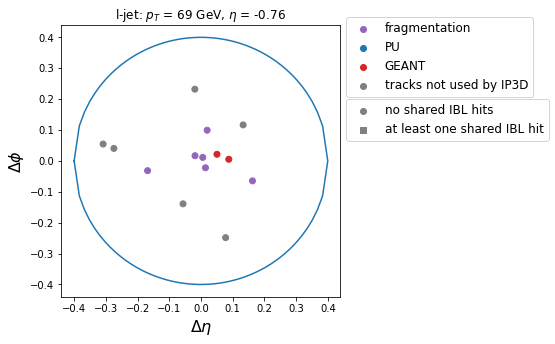

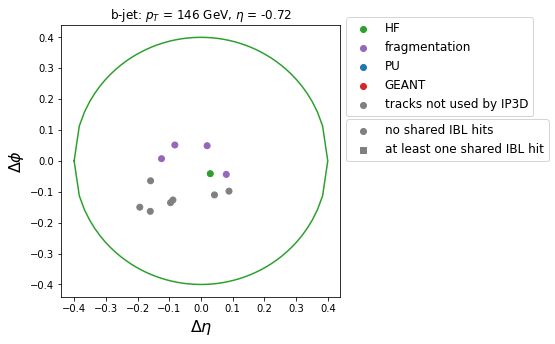

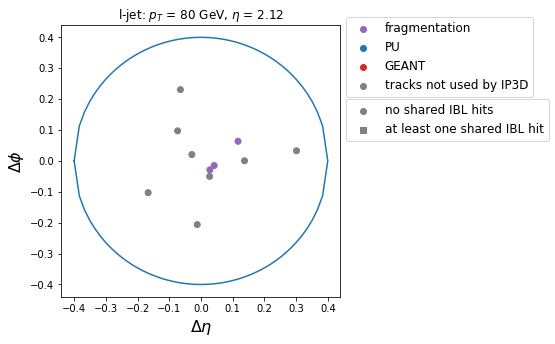

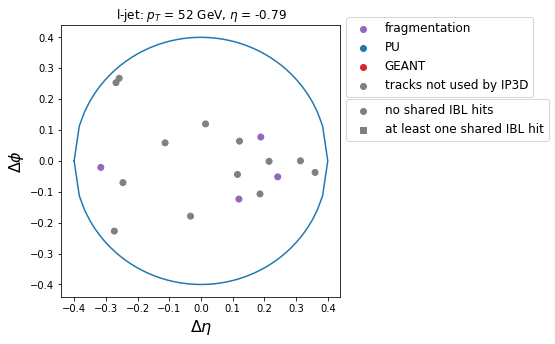

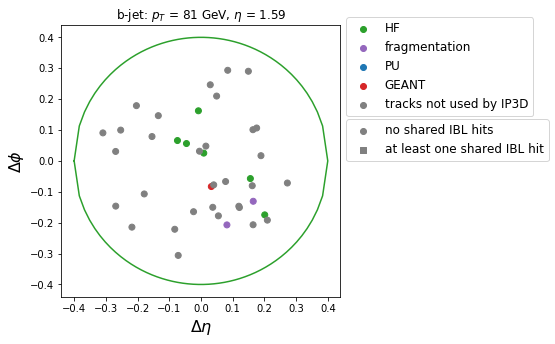

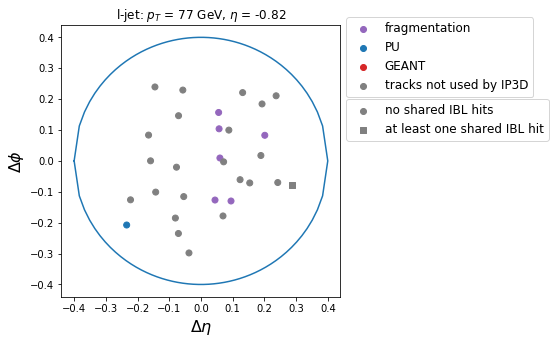

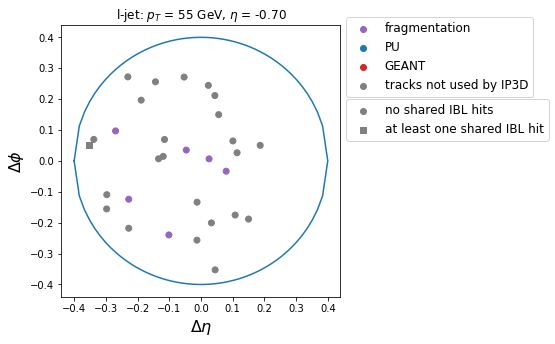

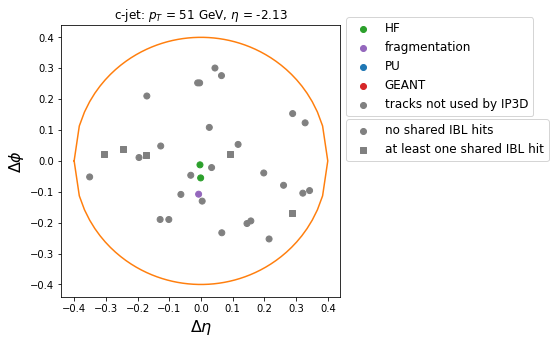

In [20]:
for i in range(10):
    jetDisplay(jet_df, output_trk_array, i, subDir='PU_studies')

Ok, I'm not sure if this makes sense to me.

A lot of the time there are *shared* hits that aren't close to other tracks. And there are also some cases with tracks that are very close that don't seem to have a corresponding shared hit.

Maybe this is because I'm plotting the tracks associated to jets with the FTAG association cone instead of all GA tracks?

Idk, I think there are probably some tracking details that aren't making sense to me, i.e, when in the stage you look for a shared hit. Maybe reading Andy's thesis could shed some light on the subject?

**Plan:** Show Michael what happens when you just look at the first 10 jets, but go on to investigate jets that have a PU track with a shared L0 hit, since this was the purpose of this study!

## Jets with a shared hit for an ip3d PU track

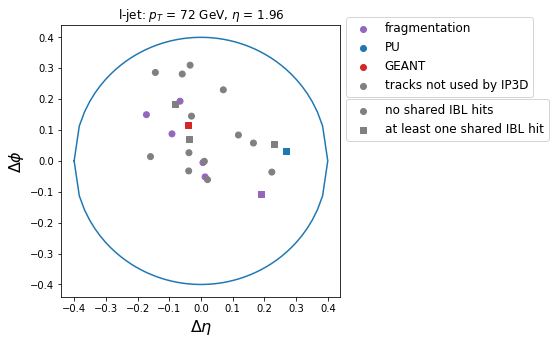

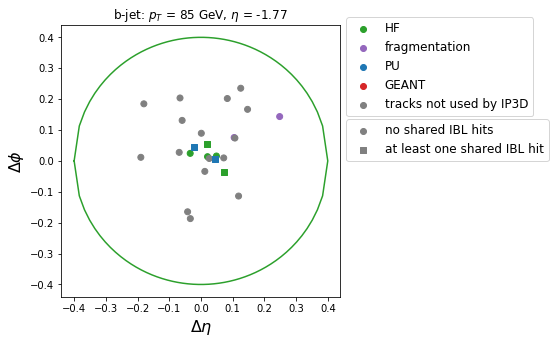

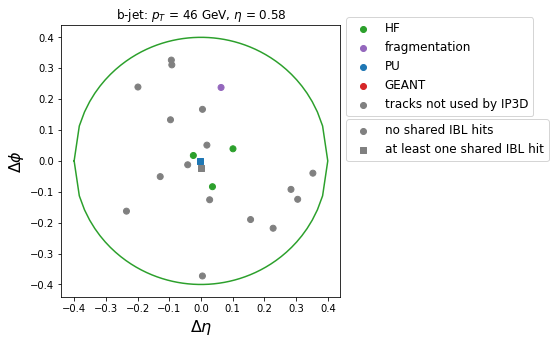

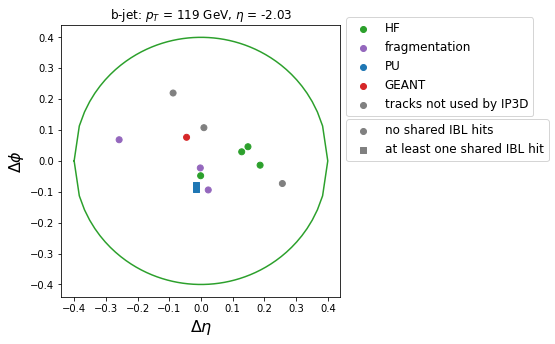

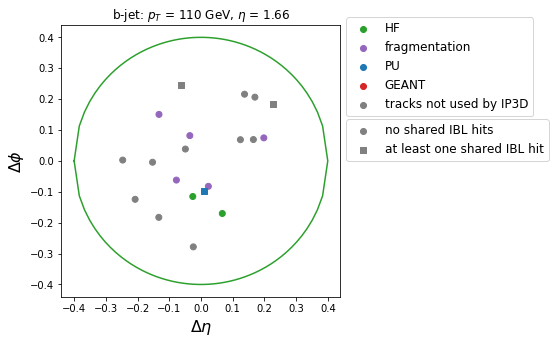

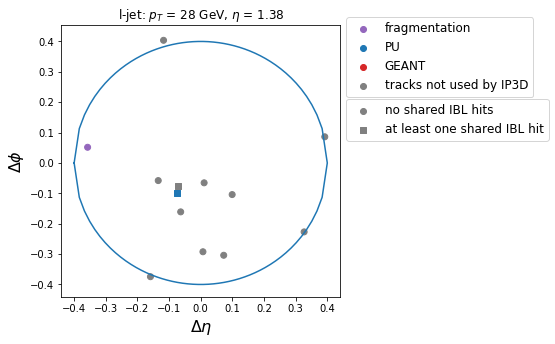

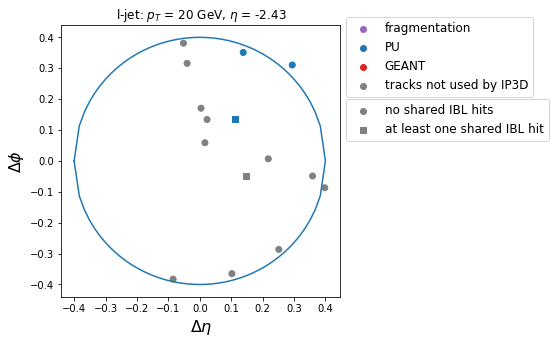

In [21]:
for ijet in range(500):
    
    # Determine which track has a shared hit in L0
    torigs = output_trk_array['jet_trk_orig'][ijet]
    tgrades = output_trk_array['jet_trk_ip3d_grade'][ijet]
    tsharedL0Hits = output_trk_array['jet_trk_nsharedBLHits'][ijet]
    
    mask = (torigs == -1) & (tgrades != -10) & (tsharedL0Hits > 0)
    
    if mask.sum() > 0:
        jetDisplay(jet_df, output_trk_array, ijet, subDir='PU_studies')

**Notes:**
- It seems like the l-jets that are having shared L0 hits tend to have higher $p_T$ than I was seeing when I just randomly looked at the first 10 jets
- How often does this happen? In 500 jets, only 10 of them had a shared L0 hit for a PU track, so the affects about 2% of the jets.

**Follow ups:**
- What's the track $p_T$ used for the gray tracks?

## Track multplicities vs $p_T$


### Step 1: Plot the track multiplicity distributions for *all* the tracks selected by the FTAG cone

There's a variable inside the Ntuple, `jet_btag_ntrk`, so I think the first thing that I should do is just sanity check to make sure that the tracks in my `jet_trk_*` arrays match the number given by this variable.

I think a sanity check on the first 100 jets should be sufficient.

In [13]:
nTrks = [jet.size for jet in output_trk_array['jet_trk_pt']]

In [14]:
for n1, n2 in zip(nTrks, jet_df.btag_ntrk.values):
    if n1 != n2:
        print(n1,n2)

Yes, these results are consistent!

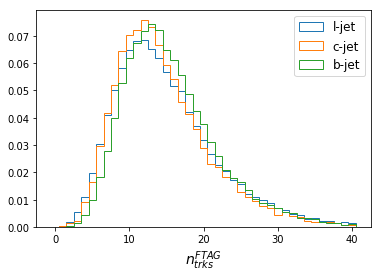

In [15]:
maxTrks = int(jet_df['btag_ntrk'].max() )

nBins = 41
myRange = (-0.5,40.5)

for pdg, flav,c in zip([0,4,5],['l','c','b'],['C0','C1','C2']):
    
    plt.hist(jet_df.loc[(jet_df.LabDr_HadF == pdg),'btag_ntrk'],
             bins=nBins,range=myRange,label='{}-jet'.format(flav),
             histtype='step', color=c, density=True)
             
plt.xlabel('$n_{trks}^{FTAG}$',fontsize=14)
plt.legend(fontsize=12) 
plt.savefig('../figures/PU_studies/btag_ntrk.pdf')
plt.show()

Conclusion: b-jets tend to have more tracks selected by this FTAG association cone.

Is this because of the $p_T$ spectrum?

### Step 2: Make scatter plots for the track multiplicities vs the jet $p_T$

In [16]:
from scipy.stats import pearsonr

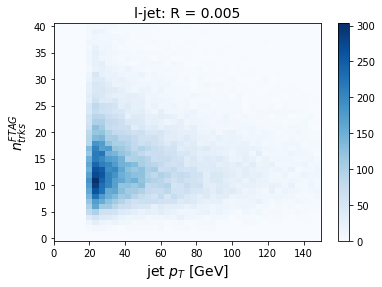

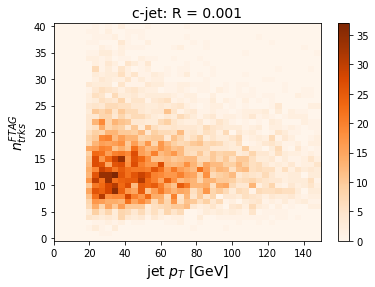

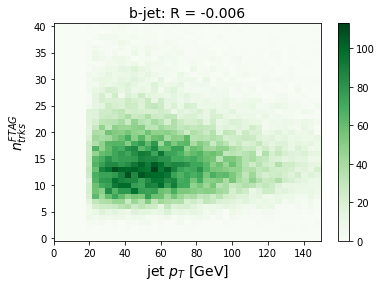

In [17]:
for pdg, flav, cmap in zip([0,4,5],['l','c','b'],['Blues','Oranges','Greens']):
    
    plt.figure()
    
    mask = (jet_df.LabDr_HadF == pdg)
    plt.hist2d(jet_df.loc[mask,'pt']/1000, jet_df.loc[mask,'btag_ntrk'],
               bins=nBins,range=((0,150),myRange),cmap=cmap)
     
    plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
    plt.ylabel('$n_{trks}^{FTAG}$',fontsize=14)  
    plt.colorbar()

    # Calculate the Pearson correlation coefficient
    R = pearsonr(jet_df.loc[mask,'pt'], jet_df.loc[mask,'btag_ntrk'])[0]
    plt.title('{}-jet: R = {:.3f}'.format(flav,R),fontsize=14)
    plt.savefig('../figures/PU_studies/{}jets_btag_ntrk_vs_pt.pdf'.format(flav))
    
plt.show()

Ok, it really *doesn't* look like tere is a correlation b/w the # of tracks and the jet $p_T$.

This was surprising to me, I'll ask Michael why this is!

### Step 3: $n_{trk}^{FTAG}$ for a *fixed* jet $p_T$

For jets with a fixed $p_T$, overlay the track multiplicity distributions and see if they line up more!!